<a href="https://colab.research.google.com/github/Vamsi-Malineni/Research-work/blob/master/raissi_research_nsfnet_alpha_beta_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import scipy.io
import time
import pandas as pd

# set random seed
np.random.seed(1234)
tf.set_random_seed(1234)


class pinn:
    # Initialize the class
    def __init__(self, x0, y0, t0, u0, v0, xb, yb, tb, ub, vb, x, y, t, layers):
        X0 = np.concatenate([x0, y0, t0], 1)  # remove the second bracket
        Xb = np.concatenate([xb, yb, tb], 1)
        X = np.concatenate([x, y, t], 1)

        self.lowb = X.min(0)  # minimal number in each column
        self.upb = X.max(0)

        self.X0 = X0
        self.Xb = Xb
        self.X = X

        self.x0 = X0[:, 0:1]
        self.y0 = X0[:, 1:2]
        self.t0 = X0[:, 2:3]
        self.xb = Xb[:, 0:1]
        self.yb = Xb[:, 1:2]
        self.tb = Xb[:, 2:3]
        self.x = X[:, 0:1]
        self.y = X[:, 1:2]
        self.t = X[:, 2:3]

        self.u0 = u0
        self.v0 = v0
        self.ub = ub
        self.vb = vb

        self.layers = layers

        # Initialize NN
        self.weights, self.biases = self.initialize_NN(layers)
        self.learning_rate = tf.placeholder(tf.float32, shape=[])

        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))

        self.x_ini_tf = tf.placeholder(tf.float32, shape=[None, self.x0.shape[1]])
        self.y_ini_tf = tf.placeholder(tf.float32, shape=[None, self.y0.shape[1]])
        self.t_ini_tf = tf.placeholder(tf.float32, shape=[None, self.t0.shape[1]])
        self.u_ini_tf = tf.placeholder(tf.float32, shape=[None, self.u0.shape[1]])
        self.v_ini_tf = tf.placeholder(tf.float32, shape=[None, self.v0.shape[1]])

        self.x_boundary_tf = tf.placeholder(tf.float32, shape=[None, self.xb.shape[1]])
        self.y_boundary_tf = tf.placeholder(tf.float32, shape=[None, self.yb.shape[1]])
        self.t_boundary_tf = tf.placeholder(tf.float32, shape=[None, self.tb.shape[1]])
        self.u_boundary_tf = tf.placeholder(tf.float32, shape=[None, self.ub.shape[1]])
        self.v_boundary_tf = tf.placeholder(tf.float32, shape=[None, self.vb.shape[1]])

        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.y_tf = tf.placeholder(tf.float32, shape=[None, self.y.shape[1]])
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])

        self.u_ini_pred, self.v_ini_pred, self.p_ini_pred = self.net_NS(self.x_ini_tf, self.y_ini_tf, self.t_ini_tf)
        
        self.u_boundary_pred, self.v_boundary_pred, self.p_boundary_pred = \
            self.net_NS(self.x_boundary_tf, self.y_boundary_tf, self.t_boundary_tf)
        
        self.u_pred, self.v_pred, self.p_pred, self.f_u_pred, self.f_v_pred, self.f_e_pred = \
            self.net_f_NS(self.x_tf, self.y_tf, self.t_tf)

        alpha, beta = 10, 10

        # set loss function
        self.loss = alpha * tf.reduce_mean(tf.square(self.u_ini_tf - self.u_ini_pred)) + \
                    alpha * tf.reduce_mean(tf.square(self.v_ini_tf - self.v_ini_pred)) + \
                    beta * tf.reduce_mean(tf.square(self.u_boundary_tf - self.u_boundary_pred)) + \
                    beta * tf.reduce_mean(tf.square(self.v_boundary_tf - self.v_boundary_pred)) + \
                    tf.reduce_mean(tf.square(self.f_u_pred)) + \
                    tf.reduce_mean(tf.square(self.f_v_pred)) + \
                    tf.reduce_mean(tf.square(self.f_e_pred))

        # set optimizer
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss,
                                                                method='L-BFGS-B',
                                                                options={'maxiter': 50000,
                                                                         'maxfun': 50000,
                                                                         'maxcor': 50,
                                                                         'maxls': 50,
                                                                         'ftol': 1.0 * np.finfo(float).eps})

        self.optimizer_Adam = tf.train.AdamOptimizer(self.learning_rate)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)

        init = tf.global_variables_initializer()
        self.sess.run(init)

# initialize the weight and bias
    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

# xavier used to initialize the weight
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

# generate the neural network
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1

        H = 2.0 * (X - self.lowb) / (self.upb - self.lowb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    # supervised data driven
    def net_NS(self, x, y, t):

        
        psi_p = self.neural_net(tf.concat([x, y, t], 1), self.weights, self.biases)
        psi = psi_p[:, 0:1]
        p   = psi_p[:, 1:2]
        
        u=tf.gradients(psi,y)[0]
        v=(-1) * tf.gradients(psi,x)[0]

        return u, v, p

    # unsupervised NS residual
    def net_f_NS(self, x, y, t):

        psi_p = self.neural_net(tf.concat([x, y, t], 1), self.weights, self.biases)
        psi = psi_p[:, 0:1]
        p   = psi_p[:, 1:2]
        
        u=tf.gradients(psi,y)[0]
        v=(-1) * tf.gradients(psi,x)[0]
        
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_y = tf.gradients(u, y)[0]
        u_xx = tf.gradients(u_x, x)[0]
        u_yy = tf.gradients(u_y, y)[0]

        v_t = tf.gradients(v, t)[0]
        v_x = tf.gradients(v, x)[0]
        v_y = tf.gradients(v, y)[0]
        v_xx = tf.gradients(v_x, x)[0]
        v_yy = tf.gradients(v_y, y)[0]

        p_x = tf.gradients(p, x)[0]
        p_y = tf.gradients(p, y)[0]

        f_u = u_t + (u * u_x + v * u_y) + p_x - 0.01 * (u_xx + u_yy)
        f_v = v_t + (u * v_x + v * v_y) + p_y - 0.01 * (v_xx + v_yy)
        f_e = 0.0

        return u, v, p, f_u, f_v, f_e

    def callback(self, loss):
        print('Loss: %.3e' % loss)

# tf_dict is used to connect model variable and data

    def Adam_train(self, nIter=5000, learning_rate=1e-3):

        tf_dict = {self.x_ini_tf: self.x0, self.y_ini_tf: self.y0,
                   self.t_ini_tf: self.t0, self.u_ini_tf: self.u0,
                   self.v_ini_tf: self.v0, self.x_boundary_tf: self.xb,
                   self.y_boundary_tf: self.yb, self.t_boundary_tf: self.tb,
                   self.u_boundary_tf: self.ub, self.v_boundary_tf: self.vb,
                   self.x_tf: self.x, self.y_tf: self.y, self.t_tf: self.t,
                   self.learning_rate: learning_rate}

        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
# later here should add dynamic strategy here
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' %
                      (it, loss_value, elapsed))
                start_time = time.time()

# two step train BFGS used to finetune the result
    def BFGS_train(self):

        tf_dict = {self.x_ini_tf: self.x0, self.y_ini_tf: self.y0,
                   self.t_ini_tf: self.t0, self.u_ini_tf: self.u0,
                   self.v_ini_tf: self.v0, self.x_boundary_tf: self.xb,
                   self.y_boundary_tf: self.yb, self.t_boundary_tf: self.tb,
                   self.u_boundary_tf: self.ub, self.v_boundary_tf: self.vb,
                   self.x_tf: self.x, self.y_tf: self.y, self.t_tf: self.t}

        self.optimizer.minimize(self.sess,
                                feed_dict=tf_dict,
                                fetches=[self.loss],
                                loss_callback=self.callback)


    def predict(self, x_star, y_star, t_star):

        tf_dict = {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star}

        u_star = self.sess.run(self.u_pred, tf_dict)
        v_star = self.sess.run(self.v_pred, tf_dict)
        p_star = self.sess.run(self.p_pred, tf_dict)

        return u_star, v_star, p_star

In [ ]:

if __name__ == "__main__":

    N_train = 14000

    layers = [3, 20, 20, 20, 20,20,20,20,20 , 2]

    # Load Data
    path=r"C:\Users\Admin\Downloads\all_pressures"
    uvel=pd.read_csv(path+r"\u_vel.csv")
    uvel=uvel.to_numpy()

    vvel=pd.read_csv(path+r"\v_vel.csv")
    vvel=vvel.to_numpy()

    press=pd.read_csv(path+r"\static_press.csv")
    press=press.to_numpy()

    xy=pd.read_csv(path+r"\xy.csv")
    xy=xy.to_numpy()

    t=pd.read_csv(path+r"\time.csv")
    t=t.to_numpy()

    N=xy.shape[0]
    T=t.shape[0]
    idx1 = np.arange(0, N*T)

    XX = np.tile(xy[:,0:1], (1,T)) # N x T
    YY = np.tile(xy[:,1:2], (1,T)) # N x T
    TT = np.tile(t, (1,N)).T # N x T

    x = XX.flatten()[:,None] # NT x 1
    y = YY.flatten()[:,None] # NT x 1
    t = TT.flatten()[:,None] # NT x 1

    u = uvel.flatten()[:,None] # NT x 1
    v = vvel.flatten()[:,None] # NT x 1
    p = press.flatten()[:,None] # NT x 1

    # need add unsupervised part
    ax=np.unique(x)
    xmin=min(ax)
    xmax=max(ax)
    ay=np.unique(y)
    ymin=min(ay)
    ymax=max(ay)


    data1=np.concatenate([x ,y ,t , u , v ,p ],1)
    data2=data1[:,:][data1[:,2]<=7]
    data3=data2[:,:][data2[:,0]>=xmin]
    data4=data3[:,:][data3[:,0]<=xmax]
    data5=data4[:,:][data4[:,1]>=ymin]
    data_domain=data5[:,:][data5[:,1]<=ymax]

    data_t0=data_domain[:,:][data_domain[:,2]==0]

    data_y1=data_domain[:,:][data_domain[:,0]==xmin]
    data_y8=data_domain[:,:][data_domain[:,0]==xmax]
    data_x=data_domain[:,:][data_domain[:,1]==ymin]
    data_x2=data_domain[:,:][data_domain[:,1]==ymax]

    data_sup_b_train = np.concatenate([data_y1, data_y8, data_x, data_x2], 0)

    idx = np.random.choice(data_domain.shape[0], N_train, replace=False)

    x_train = data_domain[idx, 0].reshape(data_domain[idx, 0].shape[0], 1)
    y_train = data_domain[idx, 1].reshape(data_domain[idx, 1].shape[0], 1)
    t_train = data_domain[idx, 2].reshape(data_domain[idx, 2].shape[0], 1)

    x0_train = data_t0[:, 0].reshape(data_t0[:, 0].shape[0], 1)
    y0_train = data_t0[:, 1].reshape(data_t0[:, 1].shape[0], 1)
    t0_train = data_t0[:, 2].reshape(data_t0[:, 2].shape[0], 1)
    u0_train = data_t0[:, 3].reshape(data_t0[:, 3].shape[0], 1)
    v0_train = data_t0[:, 4].reshape(data_t0[:, 4].shape[0], 1)

    xb_train = data_sup_b_train[:, 0].reshape(data_sup_b_train[:, 0].shape[0], 1)
    yb_train = data_sup_b_train[:, 1].reshape(data_sup_b_train[:, 1].shape[0], 1)
    tb_train = data_sup_b_train[:, 2].reshape(data_sup_b_train[:, 2].shape[0], 1)
    ub_train = data_sup_b_train[:, 3].reshape(data_sup_b_train[:, 3].shape[0], 1)
    vb_train = data_sup_b_train[:, 4].reshape(data_sup_b_train[:, 4].shape[0], 1)

    model =     pinn(x0_train, y0_train, t0_train, u0_train, v0_train, xb_train,
                     yb_train, tb_train, ub_train, vb_train, x_train, y_train, t_train,
                     layers)

    model.Adam_train(5000, 1e-3)
    model.Adam_train(5000, 1e-4)
    model.Adam_train(50000, 1e-5)
    model.Adam_train(50000, 1e-6)
    model.BFGS_train()

    # Test Data
    snap = np.array([100])
    x_star = xy[:, 0:1]
    y_star = xy[:, 1:2]
    t_star = TT[:, snap]

    u_star = uvel[:, snap]
    v_star = vvel[:, snap]
    p_star = press[:, snap]

    # Prediction
    u_pred, v_pred, p_pred = model.predict(x_star, y_star, t_star)

    # Error
    error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
    error_v = np.linalg.norm(v_star - v_pred, 2) / np.linalg.norm(v_star, 2)
    error_p = np.linalg.norm(p_star - p_pred, 2) / np.linalg.norm(p_star, 2)

    print('Error u: %e' % error_u)
    print('Error v: %e' % error_v)
    print('Error p: %e' % error_p)





Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Quadro P620, pci bus id: 0000:01:00.0, compute capability: 6.1

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



It: 0, Loss: 1.680e+01, Time: 10.12
It: 10, Loss: 4.447e+00, Time: 3.05
It: 20, Loss: 3.688e+00, Time: 3.03
It: 30, Loss: 3.141e+00, Time: 3.01
It: 40, Loss: 2.580e+00, Time: 3.01
It: 50, Loss: 2.220e+00, Time: 3.01
It: 60, Loss: 2.000e+00, Time: 3.03
It: 70, Loss: 1.871e+00, Time: 2.98
It: 80, Loss: 1.785e+00, Time: 2.99
It: 90, Loss: 1.724e+00, Time: 3.00
It: 100, Loss: 1.675e+00, Time: 3.00
It: 110, Loss: 1.635e+00, Time: 3.00
It: 120, Loss: 1.600e+00, Time: 3.01
It: 130, Loss:

It: 1760, Loss: 6.630e-01, Time: 2.98
It: 1770, Loss: 6.603e-01, Time: 3.01
It: 1780, Loss: 6.582e-01, Time: 3.01
It: 1790, Loss: 6.562e-01, Time: 2.99
It: 1800, Loss: 6.542e-01, Time: 3.01
It: 1810, Loss: 6.521e-01, Time: 3.03
It: 1820, Loss: 6.501e-01, Time: 2.99
It: 1830, Loss: 6.481e-01, Time: 3.02
It: 1840, Loss: 6.461e-01, Time: 2.99
It: 1850, Loss: 6.441e-01, Time: 3.00
It: 1860, Loss: 6.421e-01, Time: 2.99
It: 1870, Loss: 6.401e-01, Time: 2.99
It: 1880, Loss: 6.381e-01, Time: 3.03
It: 1890, Loss: 6.375e-01, Time: 3.07
It: 1900, Loss: 6.476e-01, Time: 3.03
It: 1910, Loss: 6.721e-01, Time: 3.15
It: 1920, Loss: 6.431e-01, Time: 3.14
It: 1930, Loss: 6.327e-01, Time: 3.04
It: 1940, Loss: 6.285e-01, Time: 3.00
It: 1950, Loss: 6.268e-01, Time: 3.00
It: 1960, Loss: 6.249e-01, Time: 3.02
It: 1970, Loss: 6.232e-01, Time: 3.03
It: 1980, Loss: 6.214e-01, Time: 3.00
It: 1990, Loss: 6.196e-01, Time: 2.98
It: 2000, Loss: 6.180e-01, Time: 3.00
It: 2010, Loss: 7.156e-01, Time: 3.02
It: 2020, Lo

It: 3920, Loss: 4.483e-01, Time: 2.97
It: 3930, Loss: 4.476e-01, Time: 2.98
It: 3940, Loss: 4.538e-01, Time: 2.96
It: 3950, Loss: 4.611e-01, Time: 2.98
It: 3960, Loss: 4.540e-01, Time: 2.96
It: 3970, Loss: 4.591e-01, Time: 2.99
It: 3980, Loss: 4.452e-01, Time: 3.00
It: 3990, Loss: 4.457e-01, Time: 2.99
It: 4000, Loss: 4.441e-01, Time: 3.00
It: 4010, Loss: 4.429e-01, Time: 2.95
It: 4020, Loss: 4.421e-01, Time: 2.97
It: 4030, Loss: 4.414e-01, Time: 2.99
It: 4040, Loss: 4.406e-01, Time: 2.97
It: 4050, Loss: 4.399e-01, Time: 3.00
It: 4060, Loss: 4.392e-01, Time: 2.99
It: 4070, Loss: 4.386e-01, Time: 2.98
It: 4080, Loss: 4.386e-01, Time: 3.00
It: 4090, Loss: 5.199e-01, Time: 2.99
It: 4100, Loss: 4.510e-01, Time: 2.99
It: 4110, Loss: 4.420e-01, Time: 2.98
It: 4120, Loss: 4.371e-01, Time: 3.01
It: 4130, Loss: 4.354e-01, Time: 2.99
It: 4140, Loss: 4.343e-01, Time: 2.96
It: 4150, Loss: 4.337e-01, Time: 3.00
It: 4160, Loss: 4.329e-01, Time: 2.99
It: 4170, Loss: 4.322e-01, Time: 2.97
It: 4180, Lo

It: 1110, Loss: 3.834e-01, Time: 2.97
It: 1120, Loss: 3.834e-01, Time: 3.01
It: 1130, Loss: 3.833e-01, Time: 2.99
It: 1140, Loss: 3.832e-01, Time: 3.01
It: 1150, Loss: 3.832e-01, Time: 2.99
It: 1160, Loss: 3.831e-01, Time: 3.02
It: 1170, Loss: 3.830e-01, Time: 3.03
It: 1180, Loss: 3.830e-01, Time: 3.06
It: 1190, Loss: 3.829e-01, Time: 2.98
It: 1200, Loss: 3.828e-01, Time: 2.97
It: 1210, Loss: 3.828e-01, Time: 2.98
It: 1220, Loss: 3.827e-01, Time: 2.98
It: 1230, Loss: 3.826e-01, Time: 2.97
It: 1240, Loss: 3.826e-01, Time: 2.97
It: 1250, Loss: 3.825e-01, Time: 2.99
It: 1260, Loss: 3.824e-01, Time: 3.03
It: 1270, Loss: 3.824e-01, Time: 2.99
It: 1280, Loss: 3.823e-01, Time: 2.98
It: 1290, Loss: 3.822e-01, Time: 3.01
It: 1300, Loss: 3.822e-01, Time: 2.97
It: 1310, Loss: 3.821e-01, Time: 3.01
It: 1320, Loss: 3.820e-01, Time: 2.97
It: 1330, Loss: 3.819e-01, Time: 3.02
It: 1340, Loss: 3.819e-01, Time: 2.98
It: 1350, Loss: 3.818e-01, Time: 2.98
It: 1360, Loss: 3.817e-01, Time: 2.98
It: 1370, Lo

It: 3270, Loss: 3.629e-01, Time: 2.97
It: 3280, Loss: 3.627e-01, Time: 3.00
It: 3290, Loss: 3.626e-01, Time: 2.97
It: 3300, Loss: 3.625e-01, Time: 2.99
It: 3310, Loss: 3.624e-01, Time: 3.00
It: 3320, Loss: 3.622e-01, Time: 2.99
It: 3330, Loss: 3.621e-01, Time: 3.00
It: 3340, Loss: 3.620e-01, Time: 3.02
It: 3350, Loss: 3.618e-01, Time: 2.97
It: 3360, Loss: 3.617e-01, Time: 2.97
It: 3370, Loss: 3.616e-01, Time: 2.98
It: 3380, Loss: 3.615e-01, Time: 2.98
It: 3390, Loss: 3.613e-01, Time: 3.00
It: 3400, Loss: 3.612e-01, Time: 3.00
It: 3410, Loss: 3.611e-01, Time: 2.98
It: 3420, Loss: 3.609e-01, Time: 2.99
It: 3430, Loss: 3.608e-01, Time: 2.99
It: 3440, Loss: 3.607e-01, Time: 2.96
It: 3450, Loss: 3.605e-01, Time: 2.99
It: 3460, Loss: 3.604e-01, Time: 2.97
It: 3470, Loss: 3.603e-01, Time: 3.00
It: 3480, Loss: 3.601e-01, Time: 3.01
It: 3490, Loss: 3.600e-01, Time: 2.99
It: 3500, Loss: 3.599e-01, Time: 3.00
It: 3510, Loss: 3.597e-01, Time: 2.96
It: 3520, Loss: 3.596e-01, Time: 2.99
It: 3530, Lo

It: 450, Loss: 3.391e-01, Time: 2.99
It: 460, Loss: 3.391e-01, Time: 2.96
It: 470, Loss: 3.391e-01, Time: 2.97
It: 480, Loss: 3.391e-01, Time: 2.97
It: 490, Loss: 3.391e-01, Time: 2.97
It: 500, Loss: 3.390e-01, Time: 2.99
It: 510, Loss: 3.390e-01, Time: 3.00
It: 520, Loss: 3.390e-01, Time: 2.98
It: 530, Loss: 3.390e-01, Time: 2.99
It: 540, Loss: 3.390e-01, Time: 3.00
It: 550, Loss: 3.390e-01, Time: 2.99
It: 560, Loss: 3.390e-01, Time: 3.03
It: 570, Loss: 3.389e-01, Time: 2.99
It: 580, Loss: 3.389e-01, Time: 2.97
It: 590, Loss: 3.389e-01, Time: 2.99
It: 600, Loss: 3.389e-01, Time: 2.96
It: 610, Loss: 3.389e-01, Time: 2.99
It: 620, Loss: 3.389e-01, Time: 3.00
It: 630, Loss: 3.389e-01, Time: 3.00
It: 640, Loss: 3.388e-01, Time: 2.98
It: 650, Loss: 3.388e-01, Time: 2.99
It: 660, Loss: 3.388e-01, Time: 2.98
It: 670, Loss: 3.388e-01, Time: 2.99
It: 680, Loss: 3.388e-01, Time: 3.00
It: 690, Loss: 3.388e-01, Time: 3.02
It: 700, Loss: 3.388e-01, Time: 2.98
It: 710, Loss: 3.387e-01, Time: 2.98
I

It: 2630, Loss: 3.343e-01, Time: 2.99
It: 2640, Loss: 3.343e-01, Time: 2.98
It: 2650, Loss: 3.342e-01, Time: 2.97
It: 2660, Loss: 3.342e-01, Time: 2.99
It: 2670, Loss: 3.342e-01, Time: 2.98
It: 2680, Loss: 3.341e-01, Time: 3.02
It: 2690, Loss: 3.341e-01, Time: 3.02
It: 2700, Loss: 3.341e-01, Time: 3.00
It: 2710, Loss: 3.340e-01, Time: 2.99
It: 2720, Loss: 3.340e-01, Time: 2.97
It: 2730, Loss: 3.340e-01, Time: 2.97
It: 2740, Loss: 3.339e-01, Time: 3.00
It: 2750, Loss: 3.339e-01, Time: 2.98
It: 2760, Loss: 3.339e-01, Time: 2.98
It: 2770, Loss: 3.338e-01, Time: 2.97
It: 2780, Loss: 3.338e-01, Time: 2.98
It: 2790, Loss: 3.338e-01, Time: 2.99
It: 2800, Loss: 3.337e-01, Time: 2.99
It: 2810, Loss: 3.337e-01, Time: 2.97
It: 2820, Loss: 3.337e-01, Time: 3.00
It: 2830, Loss: 3.336e-01, Time: 2.97
It: 2840, Loss: 3.336e-01, Time: 2.96
It: 2850, Loss: 3.336e-01, Time: 3.02
It: 2860, Loss: 3.335e-01, Time: 2.98
It: 2870, Loss: 3.335e-01, Time: 2.98
It: 2880, Loss: 3.335e-01, Time: 3.00
It: 2890, Lo

It: 4790, Loss: 3.249e-01, Time: 3.01
It: 4800, Loss: 3.249e-01, Time: 2.98
It: 4810, Loss: 3.248e-01, Time: 2.96
It: 4820, Loss: 3.248e-01, Time: 3.00
It: 4830, Loss: 3.247e-01, Time: 3.02
It: 4840, Loss: 3.247e-01, Time: 3.00
It: 4850, Loss: 3.246e-01, Time: 2.98
It: 4860, Loss: 3.246e-01, Time: 3.01
It: 4870, Loss: 3.245e-01, Time: 3.00
It: 4880, Loss: 3.245e-01, Time: 3.00
It: 4890, Loss: 3.244e-01, Time: 3.00
It: 4900, Loss: 3.244e-01, Time: 2.97
It: 4910, Loss: 3.243e-01, Time: 2.99
It: 4920, Loss: 3.243e-01, Time: 2.98
It: 4930, Loss: 3.242e-01, Time: 2.98
It: 4940, Loss: 3.242e-01, Time: 2.98
It: 4950, Loss: 3.241e-01, Time: 2.96
It: 4960, Loss: 3.241e-01, Time: 2.97
It: 4970, Loss: 3.240e-01, Time: 2.96
It: 4980, Loss: 3.240e-01, Time: 2.99
It: 4990, Loss: 3.239e-01, Time: 2.99
It: 5000, Loss: 3.239e-01, Time: 2.97
It: 5010, Loss: 3.238e-01, Time: 3.02
It: 5020, Loss: 3.238e-01, Time: 3.04
It: 5030, Loss: 3.238e-01, Time: 2.97
It: 5040, Loss: 3.237e-01, Time: 2.99
It: 5050, Lo

It: 6950, Loss: 3.156e-01, Time: 3.02
It: 6960, Loss: 3.155e-01, Time: 2.99
It: 6970, Loss: 3.155e-01, Time: 3.02
It: 6980, Loss: 3.155e-01, Time: 3.00
It: 6990, Loss: 3.154e-01, Time: 2.99
It: 7000, Loss: 3.154e-01, Time: 2.98
It: 7010, Loss: 3.153e-01, Time: 2.96
It: 7020, Loss: 3.153e-01, Time: 2.97
It: 7030, Loss: 3.153e-01, Time: 2.99
It: 7040, Loss: 3.152e-01, Time: 3.02
It: 7050, Loss: 3.152e-01, Time: 2.98
It: 7060, Loss: 3.152e-01, Time: 2.96
It: 7070, Loss: 3.151e-01, Time: 2.99
It: 7080, Loss: 3.151e-01, Time: 3.00
It: 7090, Loss: 3.150e-01, Time: 3.00
It: 7100, Loss: 3.150e-01, Time: 3.03
It: 7110, Loss: 3.150e-01, Time: 2.98
It: 7120, Loss: 3.149e-01, Time: 2.99
It: 7130, Loss: 3.149e-01, Time: 3.00
It: 7140, Loss: 3.148e-01, Time: 2.98
It: 7150, Loss: 3.148e-01, Time: 3.03
It: 7160, Loss: 3.148e-01, Time: 2.98
It: 7170, Loss: 3.147e-01, Time: 2.97
It: 7180, Loss: 3.147e-01, Time: 2.98
It: 7190, Loss: 3.147e-01, Time: 3.00
It: 7200, Loss: 3.146e-01, Time: 3.00
It: 7210, Lo

It: 9110, Loss: 3.081e-01, Time: 2.98
It: 9120, Loss: 3.081e-01, Time: 2.97
It: 9130, Loss: 3.080e-01, Time: 2.98
It: 9140, Loss: 3.080e-01, Time: 3.02
It: 9150, Loss: 3.080e-01, Time: 2.99
It: 9160, Loss: 3.080e-01, Time: 2.98
It: 9170, Loss: 3.079e-01, Time: 2.98
It: 9180, Loss: 3.079e-01, Time: 2.97
It: 9190, Loss: 3.079e-01, Time: 2.99
It: 9200, Loss: 3.078e-01, Time: 2.98
It: 9210, Loss: 3.078e-01, Time: 2.98
It: 9220, Loss: 3.078e-01, Time: 3.00
It: 9230, Loss: 3.077e-01, Time: 3.02
It: 9240, Loss: 3.077e-01, Time: 2.98
It: 9250, Loss: 3.077e-01, Time: 3.00
It: 9260, Loss: 3.076e-01, Time: 3.00
It: 9270, Loss: 3.076e-01, Time: 2.98
It: 9280, Loss: 3.076e-01, Time: 3.00
It: 9290, Loss: 3.076e-01, Time: 2.99
It: 9300, Loss: 3.075e-01, Time: 2.95
It: 9310, Loss: 3.075e-01, Time: 3.15
It: 9320, Loss: 3.075e-01, Time: 3.13
It: 9330, Loss: 3.074e-01, Time: 3.05
It: 9340, Loss: 3.074e-01, Time: 3.03
It: 9350, Loss: 3.074e-01, Time: 3.07
It: 9360, Loss: 3.073e-01, Time: 3.10
It: 9370, Lo

It: 11240, Loss: 3.020e-01, Time: 2.97
It: 11250, Loss: 3.020e-01, Time: 2.98
It: 11260, Loss: 3.020e-01, Time: 3.04
It: 11270, Loss: 3.020e-01, Time: 2.98
It: 11280, Loss: 3.019e-01, Time: 2.96
It: 11290, Loss: 3.019e-01, Time: 2.98
It: 11300, Loss: 3.019e-01, Time: 2.97
It: 11310, Loss: 3.019e-01, Time: 3.02
It: 11320, Loss: 3.018e-01, Time: 2.96
It: 11330, Loss: 3.018e-01, Time: 2.99
It: 11340, Loss: 3.018e-01, Time: 3.00
It: 11350, Loss: 3.018e-01, Time: 2.99
It: 11360, Loss: 3.017e-01, Time: 3.01
It: 11370, Loss: 3.017e-01, Time: 2.98
It: 11380, Loss: 3.017e-01, Time: 2.98
It: 11390, Loss: 3.017e-01, Time: 2.98
It: 11400, Loss: 3.016e-01, Time: 3.01
It: 11410, Loss: 3.016e-01, Time: 2.97
It: 11420, Loss: 3.016e-01, Time: 3.01
It: 11430, Loss: 3.016e-01, Time: 2.96
It: 11440, Loss: 3.015e-01, Time: 2.99
It: 11450, Loss: 3.015e-01, Time: 2.99
It: 11460, Loss: 3.015e-01, Time: 2.99
It: 11470, Loss: 3.015e-01, Time: 2.99
It: 11480, Loss: 3.014e-01, Time: 2.99
It: 11490, Loss: 3.014e-0

It: 13350, Loss: 2.970e-01, Time: 3.00
It: 13360, Loss: 2.970e-01, Time: 3.00
It: 13370, Loss: 2.970e-01, Time: 2.99
It: 13380, Loss: 2.970e-01, Time: 3.00
It: 13390, Loss: 2.969e-01, Time: 2.98
It: 13400, Loss: 2.969e-01, Time: 3.00
It: 13410, Loss: 2.969e-01, Time: 3.00
It: 13420, Loss: 2.969e-01, Time: 2.98
It: 13430, Loss: 2.968e-01, Time: 2.97
It: 13440, Loss: 2.968e-01, Time: 3.01
It: 13450, Loss: 2.968e-01, Time: 2.98
It: 13460, Loss: 2.968e-01, Time: 3.01
It: 13470, Loss: 2.968e-01, Time: 3.00
It: 13480, Loss: 2.967e-01, Time: 3.00
It: 13490, Loss: 2.967e-01, Time: 2.99
It: 13500, Loss: 2.967e-01, Time: 3.01
It: 13510, Loss: 2.967e-01, Time: 3.00
It: 13520, Loss: 2.967e-01, Time: 3.01
It: 13530, Loss: 2.966e-01, Time: 2.98
It: 13540, Loss: 2.966e-01, Time: 2.97
It: 13550, Loss: 2.966e-01, Time: 3.00
It: 13560, Loss: 2.966e-01, Time: 3.01
It: 13570, Loss: 2.965e-01, Time: 2.99
It: 13580, Loss: 2.965e-01, Time: 2.97
It: 13590, Loss: 2.965e-01, Time: 3.00
It: 13600, Loss: 2.965e-0

It: 15460, Loss: 2.928e-01, Time: 3.01
It: 15470, Loss: 2.928e-01, Time: 3.00
It: 15480, Loss: 2.928e-01, Time: 3.02
It: 15490, Loss: 2.928e-01, Time: 2.98
It: 15500, Loss: 2.927e-01, Time: 2.99
It: 15510, Loss: 2.927e-01, Time: 2.98
It: 15520, Loss: 2.927e-01, Time: 2.98
It: 15530, Loss: 2.927e-01, Time: 2.99
It: 15540, Loss: 2.927e-01, Time: 2.97
It: 15550, Loss: 2.927e-01, Time: 2.96
It: 15560, Loss: 2.926e-01, Time: 2.98
It: 15570, Loss: 2.926e-01, Time: 2.99
It: 15580, Loss: 2.926e-01, Time: 3.02
It: 15590, Loss: 2.926e-01, Time: 3.01
It: 15600, Loss: 2.926e-01, Time: 2.97
It: 15610, Loss: 2.925e-01, Time: 3.05
It: 15620, Loss: 2.925e-01, Time: 2.98
It: 15630, Loss: 2.925e-01, Time: 3.00
It: 15640, Loss: 2.925e-01, Time: 3.00
It: 15650, Loss: 2.925e-01, Time: 3.00
It: 15660, Loss: 2.924e-01, Time: 2.98
It: 15670, Loss: 2.924e-01, Time: 2.98
It: 15680, Loss: 2.924e-01, Time: 2.97
It: 15690, Loss: 2.924e-01, Time: 2.99
It: 15700, Loss: 2.924e-01, Time: 2.97
It: 15710, Loss: 2.924e-0

It: 17570, Loss: 2.892e-01, Time: 3.00
It: 17580, Loss: 2.892e-01, Time: 2.98
It: 17590, Loss: 2.892e-01, Time: 2.99
It: 17600, Loss: 2.892e-01, Time: 2.96
It: 17610, Loss: 2.891e-01, Time: 2.98
It: 17620, Loss: 2.891e-01, Time: 3.00
It: 17630, Loss: 2.891e-01, Time: 2.96
It: 17640, Loss: 2.891e-01, Time: 2.96
It: 17650, Loss: 2.891e-01, Time: 2.97
It: 17660, Loss: 2.891e-01, Time: 2.97
It: 17670, Loss: 2.890e-01, Time: 3.03
It: 17680, Loss: 2.890e-01, Time: 2.99
It: 17690, Loss: 2.890e-01, Time: 2.99
It: 17700, Loss: 2.890e-01, Time: 2.99
It: 17710, Loss: 2.890e-01, Time: 2.98
It: 17720, Loss: 2.890e-01, Time: 2.98
It: 17730, Loss: 2.889e-01, Time: 2.97
It: 17740, Loss: 2.889e-01, Time: 2.96
It: 17750, Loss: 2.889e-01, Time: 3.01
It: 17760, Loss: 2.889e-01, Time: 3.01
It: 17770, Loss: 2.889e-01, Time: 3.01
It: 17780, Loss: 2.889e-01, Time: 2.99
It: 17790, Loss: 2.889e-01, Time: 3.02
It: 17800, Loss: 2.888e-01, Time: 3.00
It: 17810, Loss: 2.888e-01, Time: 2.98
It: 17820, Loss: 2.888e-0

It: 19680, Loss: 2.861e-01, Time: 2.99
It: 19690, Loss: 2.860e-01, Time: 2.98
It: 19700, Loss: 2.860e-01, Time: 2.98
It: 19710, Loss: 2.860e-01, Time: 3.02
It: 19720, Loss: 2.860e-01, Time: 2.98
It: 19730, Loss: 2.860e-01, Time: 3.00
It: 19740, Loss: 2.860e-01, Time: 2.99
It: 19750, Loss: 2.860e-01, Time: 2.96
It: 19760, Loss: 2.860e-01, Time: 3.01
It: 19770, Loss: 2.859e-01, Time: 2.97
It: 19780, Loss: 2.859e-01, Time: 2.99
It: 19790, Loss: 2.859e-01, Time: 2.98
It: 19800, Loss: 2.859e-01, Time: 2.98
It: 19810, Loss: 2.859e-01, Time: 2.98
It: 19820, Loss: 2.859e-01, Time: 2.97
It: 19830, Loss: 2.858e-01, Time: 2.99
It: 19840, Loss: 2.858e-01, Time: 2.99
It: 19850, Loss: 2.858e-01, Time: 3.00
It: 19860, Loss: 2.858e-01, Time: 2.97
It: 19870, Loss: 2.858e-01, Time: 3.00
It: 19880, Loss: 2.858e-01, Time: 2.99
It: 19890, Loss: 2.858e-01, Time: 2.96
It: 19900, Loss: 2.858e-01, Time: 3.02
It: 19910, Loss: 2.857e-01, Time: 2.97
It: 19920, Loss: 2.857e-01, Time: 3.02
It: 19930, Loss: 2.857e-0

It: 21790, Loss: 2.833e-01, Time: 2.99
It: 21800, Loss: 2.833e-01, Time: 3.00
It: 21810, Loss: 2.833e-01, Time: 2.97
It: 21820, Loss: 2.833e-01, Time: 3.00
It: 21830, Loss: 2.833e-01, Time: 2.98
It: 21840, Loss: 2.833e-01, Time: 3.01
It: 21850, Loss: 2.833e-01, Time: 2.98
It: 21860, Loss: 2.832e-01, Time: 3.03
It: 21870, Loss: 2.832e-01, Time: 2.98
It: 21880, Loss: 2.832e-01, Time: 2.99
It: 21890, Loss: 2.832e-01, Time: 3.02
It: 21900, Loss: 2.832e-01, Time: 2.96
It: 21910, Loss: 2.832e-01, Time: 2.99
It: 21920, Loss: 2.832e-01, Time: 2.99
It: 21930, Loss: 2.832e-01, Time: 2.96
It: 21940, Loss: 2.832e-01, Time: 2.99
It: 21950, Loss: 2.831e-01, Time: 2.98
It: 21960, Loss: 2.831e-01, Time: 3.00
It: 21970, Loss: 2.831e-01, Time: 3.03
It: 21980, Loss: 2.831e-01, Time: 2.98
It: 21990, Loss: 2.831e-01, Time: 2.99
It: 22000, Loss: 2.831e-01, Time: 3.01
It: 22010, Loss: 2.831e-01, Time: 2.99
It: 22020, Loss: 2.831e-01, Time: 2.99
It: 22030, Loss: 2.830e-01, Time: 2.98
It: 22040, Loss: 2.830e-0

It: 23900, Loss: 2.810e-01, Time: 3.01
It: 23910, Loss: 2.810e-01, Time: 2.99
It: 23920, Loss: 2.810e-01, Time: 2.97
It: 23930, Loss: 2.810e-01, Time: 2.99
It: 23940, Loss: 2.810e-01, Time: 2.98
It: 23950, Loss: 2.809e-01, Time: 3.02
It: 23960, Loss: 2.809e-01, Time: 2.97
It: 23970, Loss: 2.809e-01, Time: 3.03
It: 23980, Loss: 2.809e-01, Time: 2.95
It: 23990, Loss: 2.809e-01, Time: 2.99
It: 24000, Loss: 2.809e-01, Time: 2.97
It: 24010, Loss: 2.809e-01, Time: 2.97
It: 24020, Loss: 2.809e-01, Time: 2.97
It: 24030, Loss: 2.809e-01, Time: 2.98
It: 24040, Loss: 2.808e-01, Time: 3.03
It: 24050, Loss: 2.808e-01, Time: 2.98
It: 24060, Loss: 2.808e-01, Time: 2.98
It: 24070, Loss: 2.808e-01, Time: 2.99
It: 24080, Loss: 2.808e-01, Time: 2.96
It: 24090, Loss: 2.808e-01, Time: 3.00
It: 24100, Loss: 2.808e-01, Time: 3.02
It: 24110, Loss: 2.808e-01, Time: 3.02
It: 24120, Loss: 2.808e-01, Time: 3.01
It: 24130, Loss: 2.808e-01, Time: 3.00
It: 24140, Loss: 2.807e-01, Time: 3.00
It: 24150, Loss: 2.807e-0

It: 26010, Loss: 2.790e-01, Time: 2.97
It: 26020, Loss: 2.790e-01, Time: 2.97
It: 26030, Loss: 2.789e-01, Time: 2.98
It: 26040, Loss: 2.789e-01, Time: 2.99
It: 26050, Loss: 2.789e-01, Time: 2.99
It: 26060, Loss: 2.789e-01, Time: 2.99
It: 26070, Loss: 2.789e-01, Time: 2.98
It: 26080, Loss: 2.789e-01, Time: 3.03
It: 26090, Loss: 2.789e-01, Time: 2.99
It: 26100, Loss: 2.789e-01, Time: 2.98
It: 26110, Loss: 2.789e-01, Time: 2.97
It: 26120, Loss: 2.789e-01, Time: 3.00
It: 26130, Loss: 2.788e-01, Time: 3.01
It: 26140, Loss: 2.788e-01, Time: 2.99
It: 26150, Loss: 2.788e-01, Time: 3.00
It: 26160, Loss: 2.788e-01, Time: 2.99
It: 26170, Loss: 2.788e-01, Time: 2.99
It: 26180, Loss: 2.788e-01, Time: 2.98
It: 26190, Loss: 2.788e-01, Time: 3.00
It: 26200, Loss: 2.788e-01, Time: 2.97
It: 26210, Loss: 2.788e-01, Time: 2.99
It: 26220, Loss: 2.788e-01, Time: 2.97
It: 26230, Loss: 2.788e-01, Time: 2.99
It: 26240, Loss: 2.787e-01, Time: 2.98
It: 26250, Loss: 2.787e-01, Time: 2.98
It: 26260, Loss: 2.787e-0

It: 28120, Loss: 2.772e-01, Time: 2.98
It: 28130, Loss: 2.772e-01, Time: 3.01
It: 28140, Loss: 2.772e-01, Time: 2.99
It: 28150, Loss: 2.772e-01, Time: 2.97
It: 28160, Loss: 2.772e-01, Time: 2.98
It: 28170, Loss: 2.771e-01, Time: 2.96
It: 28180, Loss: 2.771e-01, Time: 3.00
It: 28190, Loss: 2.771e-01, Time: 2.98
It: 28200, Loss: 2.771e-01, Time: 2.98
It: 28210, Loss: 2.771e-01, Time: 2.97
It: 28220, Loss: 2.771e-01, Time: 3.01
It: 28230, Loss: 2.771e-01, Time: 2.98
It: 28240, Loss: 2.771e-01, Time: 3.01
It: 28250, Loss: 2.771e-01, Time: 2.98
It: 28260, Loss: 2.771e-01, Time: 2.98
It: 28270, Loss: 2.771e-01, Time: 3.04
It: 28280, Loss: 2.771e-01, Time: 2.98
It: 28290, Loss: 2.771e-01, Time: 3.06
It: 28300, Loss: 2.770e-01, Time: 3.01
It: 28310, Loss: 2.770e-01, Time: 2.99
It: 28320, Loss: 2.770e-01, Time: 2.98
It: 28330, Loss: 2.770e-01, Time: 2.97
It: 28340, Loss: 2.770e-01, Time: 2.99
It: 28350, Loss: 2.770e-01, Time: 2.98
It: 28360, Loss: 2.770e-01, Time: 2.98
It: 28370, Loss: 2.770e-0

It: 30230, Loss: 2.757e-01, Time: 3.00
It: 30240, Loss: 2.757e-01, Time: 3.04
It: 30250, Loss: 2.757e-01, Time: 3.00
It: 30260, Loss: 2.756e-01, Time: 3.00
It: 30270, Loss: 2.756e-01, Time: 3.01
It: 30280, Loss: 2.756e-01, Time: 3.00
It: 30290, Loss: 2.756e-01, Time: 3.01
It: 30300, Loss: 2.756e-01, Time: 3.01
It: 30310, Loss: 2.756e-01, Time: 2.98
It: 30320, Loss: 2.756e-01, Time: 3.02
It: 30330, Loss: 2.756e-01, Time: 3.01
It: 30340, Loss: 2.756e-01, Time: 3.00
It: 30350, Loss: 2.756e-01, Time: 3.04
It: 30360, Loss: 2.756e-01, Time: 3.02
It: 30370, Loss: 2.756e-01, Time: 3.00
It: 30380, Loss: 2.756e-01, Time: 3.02
It: 30390, Loss: 2.756e-01, Time: 2.99
It: 30400, Loss: 2.756e-01, Time: 2.99
It: 30410, Loss: 2.755e-01, Time: 3.00
It: 30420, Loss: 2.755e-01, Time: 3.00
It: 30430, Loss: 2.755e-01, Time: 3.00
It: 30440, Loss: 2.755e-01, Time: 2.99
It: 30450, Loss: 2.755e-01, Time: 2.99
It: 30460, Loss: 2.755e-01, Time: 2.99
It: 30470, Loss: 2.755e-01, Time: 3.00
It: 30480, Loss: 2.755e-0

It: 32340, Loss: 2.743e-01, Time: 3.00
It: 32350, Loss: 2.743e-01, Time: 3.01
It: 32360, Loss: 2.743e-01, Time: 3.03
It: 32370, Loss: 2.743e-01, Time: 2.98
It: 32380, Loss: 2.743e-01, Time: 3.03
It: 32390, Loss: 2.743e-01, Time: 3.01
It: 32400, Loss: 2.743e-01, Time: 2.99
It: 32410, Loss: 2.743e-01, Time: 3.02
It: 32420, Loss: 2.743e-01, Time: 3.00
It: 32430, Loss: 2.743e-01, Time: 2.99
It: 32440, Loss: 2.743e-01, Time: 3.04
It: 32450, Loss: 2.743e-01, Time: 3.02
It: 32460, Loss: 2.743e-01, Time: 3.00
It: 32470, Loss: 2.743e-01, Time: 3.04
It: 32480, Loss: 2.743e-01, Time: 3.10
It: 32490, Loss: 2.742e-01, Time: 3.09
It: 32500, Loss: 2.742e-01, Time: 3.02
It: 32510, Loss: 2.742e-01, Time: 3.04
It: 32520, Loss: 2.742e-01, Time: 3.01
It: 32530, Loss: 2.742e-01, Time: 2.99
It: 32540, Loss: 2.742e-01, Time: 3.00
It: 32550, Loss: 2.742e-01, Time: 2.98
It: 32560, Loss: 2.742e-01, Time: 3.02
It: 32570, Loss: 2.742e-01, Time: 2.98
It: 32580, Loss: 2.742e-01, Time: 2.97
It: 32590, Loss: 2.742e-0

It: 34450, Loss: 2.732e-01, Time: 3.01
It: 34460, Loss: 2.732e-01, Time: 2.97
It: 34470, Loss: 2.731e-01, Time: 2.96
It: 34480, Loss: 2.731e-01, Time: 2.96
It: 34490, Loss: 2.731e-01, Time: 3.01
It: 34500, Loss: 2.731e-01, Time: 2.97
It: 34510, Loss: 2.731e-01, Time: 3.00
It: 34520, Loss: 2.731e-01, Time: 2.98
It: 34530, Loss: 2.731e-01, Time: 3.00
It: 34540, Loss: 2.731e-01, Time: 2.96
It: 34550, Loss: 2.731e-01, Time: 2.98
It: 34560, Loss: 2.731e-01, Time: 2.97
It: 34570, Loss: 2.731e-01, Time: 2.98
It: 34580, Loss: 2.731e-01, Time: 3.01
It: 34590, Loss: 2.731e-01, Time: 2.97
It: 34600, Loss: 2.731e-01, Time: 3.02
It: 34610, Loss: 2.731e-01, Time: 2.97
It: 34620, Loss: 2.731e-01, Time: 2.97
It: 34630, Loss: 2.731e-01, Time: 3.00
It: 34640, Loss: 2.731e-01, Time: 2.97
It: 34650, Loss: 2.731e-01, Time: 3.02
It: 34660, Loss: 2.730e-01, Time: 2.98
It: 34670, Loss: 2.730e-01, Time: 2.99
It: 34680, Loss: 2.730e-01, Time: 2.99
It: 34690, Loss: 2.730e-01, Time: 3.00
It: 34700, Loss: 2.730e-0

It: 36560, Loss: 2.721e-01, Time: 2.96
It: 36570, Loss: 2.721e-01, Time: 2.99
It: 36580, Loss: 2.721e-01, Time: 3.01
It: 36590, Loss: 2.721e-01, Time: 3.02
It: 36600, Loss: 2.721e-01, Time: 2.99
It: 36610, Loss: 2.721e-01, Time: 2.98
It: 36620, Loss: 2.721e-01, Time: 3.00
It: 36630, Loss: 2.721e-01, Time: 2.98
It: 36640, Loss: 2.720e-01, Time: 2.99
It: 36650, Loss: 2.720e-01, Time: 3.03
It: 36660, Loss: 2.720e-01, Time: 2.99
It: 36670, Loss: 2.720e-01, Time: 2.98
It: 36680, Loss: 2.720e-01, Time: 2.98
It: 36690, Loss: 2.720e-01, Time: 2.99
It: 36700, Loss: 2.720e-01, Time: 3.00
It: 36710, Loss: 2.720e-01, Time: 3.00
It: 36720, Loss: 2.720e-01, Time: 3.00
It: 36730, Loss: 2.720e-01, Time: 2.99
It: 36740, Loss: 2.720e-01, Time: 2.99
It: 36750, Loss: 2.720e-01, Time: 2.97
It: 36760, Loss: 2.720e-01, Time: 2.98
It: 36770, Loss: 2.720e-01, Time: 2.99
It: 36780, Loss: 2.720e-01, Time: 3.00
It: 36790, Loss: 2.720e-01, Time: 2.99
It: 36800, Loss: 2.720e-01, Time: 3.01
It: 36810, Loss: 2.720e-0

It: 38670, Loss: 2.711e-01, Time: 2.98
It: 38680, Loss: 2.711e-01, Time: 3.00
It: 38690, Loss: 2.711e-01, Time: 2.98
It: 38700, Loss: 2.711e-01, Time: 2.96
It: 38710, Loss: 2.711e-01, Time: 3.01
It: 38720, Loss: 2.711e-01, Time: 2.99
It: 38730, Loss: 2.711e-01, Time: 2.99
It: 38740, Loss: 2.711e-01, Time: 2.96
It: 38750, Loss: 2.711e-01, Time: 2.98
It: 38760, Loss: 2.711e-01, Time: 2.97
It: 38770, Loss: 2.710e-01, Time: 2.97
It: 38780, Loss: 2.710e-01, Time: 3.01
It: 38790, Loss: 2.710e-01, Time: 2.99
It: 38800, Loss: 2.710e-01, Time: 3.02
It: 38810, Loss: 2.710e-01, Time: 3.00
It: 38820, Loss: 2.710e-01, Time: 2.98
It: 38830, Loss: 2.710e-01, Time: 2.99
It: 38840, Loss: 2.710e-01, Time: 2.98
It: 38850, Loss: 2.710e-01, Time: 2.99
It: 38860, Loss: 2.710e-01, Time: 3.02
It: 38870, Loss: 2.710e-01, Time: 3.00
It: 38880, Loss: 2.710e-01, Time: 3.00
It: 38890, Loss: 2.710e-01, Time: 2.98
It: 38900, Loss: 2.710e-01, Time: 2.97
It: 38910, Loss: 2.710e-01, Time: 3.00
It: 38920, Loss: 2.710e-0

It: 40780, Loss: 2.702e-01, Time: 2.99
It: 40790, Loss: 2.702e-01, Time: 3.01
It: 40800, Loss: 2.702e-01, Time: 2.99
It: 40810, Loss: 2.702e-01, Time: 3.00
It: 40820, Loss: 2.702e-01, Time: 3.02
It: 40830, Loss: 2.702e-01, Time: 2.99
It: 40840, Loss: 2.702e-01, Time: 2.98
It: 40850, Loss: 2.701e-01, Time: 3.00
It: 40860, Loss: 2.701e-01, Time: 3.00
It: 40870, Loss: 2.701e-01, Time: 2.98
It: 40880, Loss: 2.701e-01, Time: 3.00
It: 40890, Loss: 2.701e-01, Time: 2.98
It: 40900, Loss: 2.701e-01, Time: 3.02
It: 40910, Loss: 2.701e-01, Time: 2.97
It: 40920, Loss: 2.701e-01, Time: 2.97
It: 40930, Loss: 2.701e-01, Time: 3.02
It: 40940, Loss: 2.701e-01, Time: 2.99
It: 40950, Loss: 2.701e-01, Time: 2.96
It: 40960, Loss: 2.701e-01, Time: 3.00
It: 40970, Loss: 2.701e-01, Time: 2.99
It: 40980, Loss: 2.701e-01, Time: 2.99
It: 40990, Loss: 2.701e-01, Time: 2.97
It: 41000, Loss: 2.701e-01, Time: 3.01
It: 41010, Loss: 2.701e-01, Time: 2.98
It: 41020, Loss: 2.701e-01, Time: 2.99
It: 41030, Loss: 2.701e-0

It: 42890, Loss: 2.693e-01, Time: 3.02
It: 42900, Loss: 2.693e-01, Time: 3.02
It: 42910, Loss: 2.693e-01, Time: 3.00
It: 42920, Loss: 2.693e-01, Time: 3.00
It: 42930, Loss: 2.693e-01, Time: 3.01
It: 42940, Loss: 2.693e-01, Time: 3.01
It: 42950, Loss: 2.693e-01, Time: 3.02
It: 42960, Loss: 2.693e-01, Time: 3.01
It: 42970, Loss: 2.693e-01, Time: 3.02
It: 42980, Loss: 2.693e-01, Time: 2.99
It: 42990, Loss: 2.693e-01, Time: 3.01
It: 43000, Loss: 2.693e-01, Time: 2.99
It: 43010, Loss: 2.693e-01, Time: 2.99
It: 43020, Loss: 2.693e-01, Time: 3.00
It: 43030, Loss: 2.693e-01, Time: 3.01
It: 43040, Loss: 2.693e-01, Time: 2.99
It: 43050, Loss: 2.693e-01, Time: 2.99
It: 43060, Loss: 2.693e-01, Time: 3.09
It: 43070, Loss: 2.693e-01, Time: 3.00
It: 43080, Loss: 2.693e-01, Time: 2.98
It: 43090, Loss: 2.693e-01, Time: 3.00
It: 43100, Loss: 2.693e-01, Time: 3.01
It: 43110, Loss: 2.693e-01, Time: 2.99
It: 43120, Loss: 2.692e-01, Time: 3.01
It: 43130, Loss: 2.692e-01, Time: 3.03
It: 43140, Loss: 2.692e-0

It: 45000, Loss: 2.686e-01, Time: 2.99
It: 45010, Loss: 2.686e-01, Time: 2.97
It: 45020, Loss: 2.686e-01, Time: 3.00
It: 45030, Loss: 2.686e-01, Time: 2.96
It: 45040, Loss: 2.685e-01, Time: 2.98
It: 45050, Loss: 2.685e-01, Time: 2.99
It: 45060, Loss: 2.685e-01, Time: 3.02
It: 45070, Loss: 2.685e-01, Time: 2.99
It: 45080, Loss: 2.685e-01, Time: 2.98
It: 45090, Loss: 2.685e-01, Time: 3.01
It: 45100, Loss: 2.685e-01, Time: 3.00
It: 45110, Loss: 2.685e-01, Time: 3.02
It: 45120, Loss: 2.685e-01, Time: 2.98
It: 45130, Loss: 2.685e-01, Time: 2.97
It: 45140, Loss: 2.685e-01, Time: 3.00
It: 45150, Loss: 2.685e-01, Time: 3.11
It: 45160, Loss: 2.685e-01, Time: 3.01
It: 45170, Loss: 2.685e-01, Time: 2.98
It: 45180, Loss: 2.685e-01, Time: 2.98
It: 45190, Loss: 2.685e-01, Time: 2.99
It: 45200, Loss: 2.685e-01, Time: 3.01
It: 45210, Loss: 2.685e-01, Time: 2.97
It: 45220, Loss: 2.685e-01, Time: 2.97
It: 45230, Loss: 2.685e-01, Time: 2.98
It: 45240, Loss: 2.685e-01, Time: 3.02
It: 45250, Loss: 2.685e-0

It: 47110, Loss: 2.678e-01, Time: 3.01
It: 47120, Loss: 2.678e-01, Time: 3.01
It: 47130, Loss: 2.678e-01, Time: 2.97
It: 47140, Loss: 2.678e-01, Time: 2.97
It: 47150, Loss: 2.678e-01, Time: 3.02
It: 47160, Loss: 2.678e-01, Time: 3.03
It: 47170, Loss: 2.678e-01, Time: 2.98
It: 47180, Loss: 2.678e-01, Time: 2.99
It: 47190, Loss: 2.678e-01, Time: 3.01
It: 47200, Loss: 2.678e-01, Time: 3.01
It: 47210, Loss: 2.678e-01, Time: 3.01
It: 47220, Loss: 2.678e-01, Time: 2.99
It: 47230, Loss: 2.678e-01, Time: 3.04
It: 47240, Loss: 2.678e-01, Time: 2.96
It: 47250, Loss: 2.678e-01, Time: 3.01
It: 47260, Loss: 2.678e-01, Time: 2.99
It: 47270, Loss: 2.678e-01, Time: 2.99
It: 47280, Loss: 2.678e-01, Time: 2.97
It: 47290, Loss: 2.678e-01, Time: 2.99
It: 47300, Loss: 2.678e-01, Time: 3.00
It: 47310, Loss: 2.678e-01, Time: 3.00
It: 47320, Loss: 2.678e-01, Time: 2.97
It: 47330, Loss: 2.678e-01, Time: 2.98
It: 47340, Loss: 2.678e-01, Time: 2.99
It: 47350, Loss: 2.678e-01, Time: 2.99
It: 47360, Loss: 2.678e-0

It: 49220, Loss: 2.672e-01, Time: 2.97
It: 49230, Loss: 2.672e-01, Time: 3.02
It: 49240, Loss: 2.672e-01, Time: 2.99
It: 49250, Loss: 2.672e-01, Time: 3.00
It: 49260, Loss: 2.672e-01, Time: 2.97
It: 49270, Loss: 2.672e-01, Time: 3.00
It: 49280, Loss: 2.672e-01, Time: 3.02
It: 49290, Loss: 2.671e-01, Time: 2.97
It: 49300, Loss: 2.671e-01, Time: 2.99
It: 49310, Loss: 2.671e-01, Time: 2.97
It: 49320, Loss: 2.671e-01, Time: 2.96
It: 49330, Loss: 2.672e-01, Time: 3.02
It: 49340, Loss: 2.671e-01, Time: 3.01
It: 49350, Loss: 2.671e-01, Time: 2.97
It: 49360, Loss: 2.671e-01, Time: 2.99
It: 49370, Loss: 2.671e-01, Time: 2.97
It: 49380, Loss: 2.671e-01, Time: 2.99
It: 49390, Loss: 2.671e-01, Time: 3.00
It: 49400, Loss: 2.671e-01, Time: 3.01
It: 49410, Loss: 2.671e-01, Time: 2.97
It: 49420, Loss: 2.671e-01, Time: 3.01
It: 49430, Loss: 2.671e-01, Time: 2.99
It: 49440, Loss: 2.671e-01, Time: 2.97
It: 49450, Loss: 2.671e-01, Time: 2.97
It: 49460, Loss: 2.671e-01, Time: 2.97
It: 49470, Loss: 2.671e-0

It: 1390, Loss: 2.669e-01, Time: 3.03
It: 1400, Loss: 2.669e-01, Time: 2.99
It: 1410, Loss: 2.669e-01, Time: 2.97
It: 1420, Loss: 2.669e-01, Time: 2.99
It: 1430, Loss: 2.669e-01, Time: 2.98
It: 1440, Loss: 2.669e-01, Time: 3.03
It: 1450, Loss: 2.669e-01, Time: 2.97
It: 1460, Loss: 2.669e-01, Time: 3.00
It: 1470, Loss: 2.669e-01, Time: 2.96
It: 1480, Loss: 2.669e-01, Time: 2.99
It: 1490, Loss: 2.669e-01, Time: 2.99
It: 1500, Loss: 2.669e-01, Time: 2.99
It: 1510, Loss: 2.669e-01, Time: 2.98
It: 1520, Loss: 2.669e-01, Time: 3.01
It: 1530, Loss: 2.669e-01, Time: 2.98
It: 1540, Loss: 2.669e-01, Time: 2.98
It: 1550, Loss: 2.669e-01, Time: 3.01
It: 1560, Loss: 2.669e-01, Time: 3.02
It: 1570, Loss: 2.669e-01, Time: 3.00
It: 1580, Loss: 2.669e-01, Time: 3.00
It: 1590, Loss: 2.669e-01, Time: 3.00
It: 1600, Loss: 2.669e-01, Time: 2.96
It: 1610, Loss: 2.669e-01, Time: 2.98
It: 1620, Loss: 2.669e-01, Time: 3.00
It: 1630, Loss: 2.669e-01, Time: 3.03
It: 1640, Loss: 2.669e-01, Time: 2.97
It: 1650, Lo

It: 3550, Loss: 2.667e-01, Time: 3.00
It: 3560, Loss: 2.667e-01, Time: 2.99
It: 3570, Loss: 2.667e-01, Time: 3.02
It: 3580, Loss: 2.667e-01, Time: 2.97
It: 3590, Loss: 2.667e-01, Time: 2.99
It: 3600, Loss: 2.667e-01, Time: 2.99
It: 3610, Loss: 2.667e-01, Time: 3.00
It: 3620, Loss: 2.667e-01, Time: 2.97
It: 3630, Loss: 2.667e-01, Time: 2.99
It: 3640, Loss: 2.667e-01, Time: 3.00
It: 3650, Loss: 2.667e-01, Time: 2.98
It: 3660, Loss: 2.667e-01, Time: 2.98
It: 3670, Loss: 2.667e-01, Time: 3.00
It: 3680, Loss: 2.667e-01, Time: 2.97
It: 3690, Loss: 2.667e-01, Time: 3.00
It: 3700, Loss: 2.667e-01, Time: 2.96
It: 3710, Loss: 2.667e-01, Time: 3.01
It: 3720, Loss: 2.667e-01, Time: 2.98
It: 3730, Loss: 2.667e-01, Time: 2.97
It: 3740, Loss: 2.667e-01, Time: 3.00
It: 3750, Loss: 2.667e-01, Time: 3.00
It: 3760, Loss: 2.667e-01, Time: 2.97
It: 3770, Loss: 2.667e-01, Time: 2.98
It: 3780, Loss: 2.667e-01, Time: 3.01
It: 3790, Loss: 2.666e-01, Time: 2.99
It: 3800, Loss: 2.666e-01, Time: 2.97
It: 3810, Lo

It: 5710, Loss: 2.663e-01, Time: 2.99
It: 5720, Loss: 2.663e-01, Time: 2.97
It: 5730, Loss: 2.663e-01, Time: 3.01
It: 5740, Loss: 2.663e-01, Time: 2.99
It: 5750, Loss: 2.663e-01, Time: 2.98
It: 5760, Loss: 2.663e-01, Time: 3.00
It: 5770, Loss: 2.663e-01, Time: 2.97
It: 5780, Loss: 2.663e-01, Time: 2.99
It: 5790, Loss: 2.663e-01, Time: 2.97
It: 5800, Loss: 2.663e-01, Time: 2.98
It: 5810, Loss: 2.663e-01, Time: 2.99
It: 5820, Loss: 2.663e-01, Time: 2.97
It: 5830, Loss: 2.663e-01, Time: 2.97
It: 5840, Loss: 2.663e-01, Time: 2.99
It: 5850, Loss: 2.663e-01, Time: 2.99
It: 5860, Loss: 2.663e-01, Time: 2.96
It: 5870, Loss: 2.663e-01, Time: 2.99
It: 5880, Loss: 2.663e-01, Time: 2.99
It: 5890, Loss: 2.663e-01, Time: 2.98
It: 5900, Loss: 2.663e-01, Time: 2.99
It: 5910, Loss: 2.663e-01, Time: 3.00
It: 5920, Loss: 2.663e-01, Time: 2.96
It: 5930, Loss: 2.663e-01, Time: 2.97
It: 5940, Loss: 2.663e-01, Time: 2.96
It: 5950, Loss: 2.663e-01, Time: 2.98
It: 5960, Loss: 2.663e-01, Time: 2.98
It: 5970, Lo

It: 7870, Loss: 2.660e-01, Time: 2.99
It: 7880, Loss: 2.660e-01, Time: 3.00
It: 7890, Loss: 2.660e-01, Time: 2.98
It: 7900, Loss: 2.660e-01, Time: 3.02
It: 7910, Loss: 2.660e-01, Time: 3.01
It: 7920, Loss: 2.660e-01, Time: 2.99
It: 7930, Loss: 2.660e-01, Time: 2.98
It: 7940, Loss: 2.660e-01, Time: 2.97
It: 7950, Loss: 2.660e-01, Time: 3.00
It: 7960, Loss: 2.660e-01, Time: 3.00
It: 7970, Loss: 2.660e-01, Time: 2.98
It: 7980, Loss: 2.660e-01, Time: 3.01
It: 7990, Loss: 2.660e-01, Time: 2.96
It: 8000, Loss: 2.660e-01, Time: 2.99
It: 8010, Loss: 2.660e-01, Time: 3.03
It: 8020, Loss: 2.660e-01, Time: 2.98
It: 8030, Loss: 2.660e-01, Time: 2.99
It: 8040, Loss: 2.660e-01, Time: 3.00
It: 8050, Loss: 2.660e-01, Time: 3.03
It: 8060, Loss: 2.660e-01, Time: 3.00
It: 8070, Loss: 2.660e-01, Time: 2.98
It: 8080, Loss: 2.660e-01, Time: 2.98
It: 8090, Loss: 2.660e-01, Time: 2.98
It: 8100, Loss: 2.659e-01, Time: 2.96
It: 8110, Loss: 2.659e-01, Time: 2.99
It: 8120, Loss: 2.659e-01, Time: 2.98
It: 8130, Lo

It: 10030, Loss: 2.656e-01, Time: 2.98
It: 10040, Loss: 2.656e-01, Time: 2.98
It: 10050, Loss: 2.656e-01, Time: 2.98
It: 10060, Loss: 2.656e-01, Time: 3.01
It: 10070, Loss: 2.656e-01, Time: 2.98
It: 10080, Loss: 2.656e-01, Time: 2.97
It: 10090, Loss: 2.656e-01, Time: 2.98
It: 10100, Loss: 2.656e-01, Time: 2.99
It: 10110, Loss: 2.656e-01, Time: 2.97
It: 10120, Loss: 2.656e-01, Time: 2.97
It: 10130, Loss: 2.656e-01, Time: 3.00
It: 10140, Loss: 2.656e-01, Time: 3.00
It: 10150, Loss: 2.656e-01, Time: 2.97
It: 10160, Loss: 2.656e-01, Time: 3.00
It: 10170, Loss: 2.656e-01, Time: 2.99
It: 10180, Loss: 2.656e-01, Time: 2.97
It: 10190, Loss: 2.656e-01, Time: 3.00
It: 10200, Loss: 2.656e-01, Time: 2.98
It: 10210, Loss: 2.656e-01, Time: 2.99
It: 10220, Loss: 2.656e-01, Time: 2.99
It: 10230, Loss: 2.656e-01, Time: 3.01
It: 10240, Loss: 2.656e-01, Time: 2.98
It: 10250, Loss: 2.656e-01, Time: 3.01
It: 10260, Loss: 2.656e-01, Time: 3.00
It: 10270, Loss: 2.656e-01, Time: 2.98
It: 10280, Loss: 2.656e-0

It: 12140, Loss: 2.653e-01, Time: 2.99
It: 12150, Loss: 2.653e-01, Time: 3.00
It: 12160, Loss: 2.653e-01, Time: 3.00
It: 12170, Loss: 2.653e-01, Time: 3.01
It: 12180, Loss: 2.653e-01, Time: 3.01
It: 12190, Loss: 2.653e-01, Time: 2.98
It: 12200, Loss: 2.653e-01, Time: 3.00
It: 12210, Loss: 2.653e-01, Time: 2.97
It: 12220, Loss: 2.653e-01, Time: 2.98
It: 12230, Loss: 2.653e-01, Time: 2.98
It: 12240, Loss: 2.653e-01, Time: 3.00
It: 12250, Loss: 2.653e-01, Time: 2.98
It: 12260, Loss: 2.653e-01, Time: 2.99
It: 12270, Loss: 2.653e-01, Time: 3.00
It: 12280, Loss: 2.653e-01, Time: 2.97
It: 12290, Loss: 2.653e-01, Time: 2.99
It: 12300, Loss: 2.653e-01, Time: 2.96
It: 12310, Loss: 2.653e-01, Time: 3.01
It: 12320, Loss: 2.653e-01, Time: 2.97
It: 12330, Loss: 2.653e-01, Time: 3.00
It: 12340, Loss: 2.653e-01, Time: 2.99
It: 12350, Loss: 2.653e-01, Time: 2.97
It: 12360, Loss: 2.653e-01, Time: 2.99
It: 12370, Loss: 2.653e-01, Time: 3.00
It: 12380, Loss: 2.653e-01, Time: 2.98
It: 12390, Loss: 2.653e-0

It: 14250, Loss: 2.650e-01, Time: 3.02
It: 14260, Loss: 2.650e-01, Time: 2.98
It: 14270, Loss: 2.650e-01, Time: 2.97
It: 14280, Loss: 2.650e-01, Time: 3.01
It: 14290, Loss: 2.650e-01, Time: 2.99
It: 14300, Loss: 2.650e-01, Time: 2.97
It: 14310, Loss: 2.650e-01, Time: 2.99
It: 14320, Loss: 2.650e-01, Time: 2.97
It: 14330, Loss: 2.650e-01, Time: 2.97
It: 14340, Loss: 2.650e-01, Time: 2.99
It: 14350, Loss: 2.650e-01, Time: 2.99
It: 14360, Loss: 2.650e-01, Time: 2.97
It: 14370, Loss: 2.650e-01, Time: 2.98
It: 14380, Loss: 2.650e-01, Time: 3.03
It: 14390, Loss: 2.650e-01, Time: 2.98
It: 14400, Loss: 2.650e-01, Time: 2.97
It: 14410, Loss: 2.650e-01, Time: 3.01
It: 14420, Loss: 2.650e-01, Time: 2.99
It: 14430, Loss: 2.650e-01, Time: 2.96
It: 14440, Loss: 2.650e-01, Time: 2.97
It: 14450, Loss: 2.650e-01, Time: 3.03
It: 14460, Loss: 2.650e-01, Time: 3.00
It: 14470, Loss: 2.650e-01, Time: 2.98
It: 14480, Loss: 2.650e-01, Time: 2.99
It: 14490, Loss: 2.650e-01, Time: 3.00
It: 14500, Loss: 2.650e-0

It: 16360, Loss: 2.647e-01, Time: 2.98
It: 16370, Loss: 2.647e-01, Time: 2.97
It: 16380, Loss: 2.647e-01, Time: 3.01
It: 16390, Loss: 2.647e-01, Time: 2.99
It: 16400, Loss: 2.647e-01, Time: 2.98
It: 16410, Loss: 2.647e-01, Time: 2.99
It: 16420, Loss: 2.647e-01, Time: 3.00
It: 16430, Loss: 2.647e-01, Time: 3.02
It: 16440, Loss: 2.647e-01, Time: 3.03
It: 16450, Loss: 2.647e-01, Time: 2.98
It: 16460, Loss: 2.647e-01, Time: 2.98
It: 16470, Loss: 2.647e-01, Time: 3.00
It: 16480, Loss: 2.647e-01, Time: 2.97
It: 16490, Loss: 2.647e-01, Time: 3.04
It: 16500, Loss: 2.647e-01, Time: 3.01
It: 16510, Loss: 2.647e-01, Time: 2.97
It: 16520, Loss: 2.646e-01, Time: 3.00
It: 16530, Loss: 2.646e-01, Time: 2.99
It: 16540, Loss: 2.646e-01, Time: 2.99
It: 16550, Loss: 2.646e-01, Time: 2.99
It: 16560, Loss: 2.646e-01, Time: 2.98
It: 16570, Loss: 2.646e-01, Time: 3.01
It: 16580, Loss: 2.646e-01, Time: 2.96
It: 16590, Loss: 2.646e-01, Time: 3.00
It: 16600, Loss: 2.646e-01, Time: 2.97
It: 16610, Loss: 2.646e-0

It: 18470, Loss: 2.644e-01, Time: 2.96
It: 18480, Loss: 2.644e-01, Time: 2.98
It: 18490, Loss: 2.644e-01, Time: 3.00
It: 18500, Loss: 2.644e-01, Time: 2.99
It: 18510, Loss: 2.644e-01, Time: 2.97
It: 18520, Loss: 2.644e-01, Time: 2.98
It: 18530, Loss: 2.644e-01, Time: 2.98
It: 18540, Loss: 2.643e-01, Time: 2.99
It: 18550, Loss: 2.643e-01, Time: 2.98
It: 18560, Loss: 2.643e-01, Time: 2.96
It: 18570, Loss: 2.643e-01, Time: 3.01
It: 18580, Loss: 2.643e-01, Time: 3.01
It: 18590, Loss: 2.643e-01, Time: 2.99
It: 18600, Loss: 2.643e-01, Time: 3.01
It: 18610, Loss: 2.643e-01, Time: 2.97
It: 18620, Loss: 2.643e-01, Time: 2.97
It: 18630, Loss: 2.643e-01, Time: 2.97
It: 18640, Loss: 2.643e-01, Time: 3.03
It: 18650, Loss: 2.643e-01, Time: 2.98
It: 18660, Loss: 2.643e-01, Time: 2.99
It: 18670, Loss: 2.643e-01, Time: 2.99
It: 18680, Loss: 2.643e-01, Time: 3.00
It: 18690, Loss: 2.643e-01, Time: 2.98
It: 18700, Loss: 2.643e-01, Time: 2.99
It: 18710, Loss: 2.643e-01, Time: 2.98
It: 18720, Loss: 2.643e-0

It: 20580, Loss: 2.641e-01, Time: 3.00
It: 20590, Loss: 2.640e-01, Time: 3.01
It: 20600, Loss: 2.640e-01, Time: 2.99
It: 20610, Loss: 2.640e-01, Time: 3.02
It: 20620, Loss: 2.640e-01, Time: 3.01
It: 20630, Loss: 2.640e-01, Time: 2.98
It: 20640, Loss: 2.640e-01, Time: 2.96
It: 20650, Loss: 2.640e-01, Time: 3.00
It: 20660, Loss: 2.640e-01, Time: 2.95
It: 20670, Loss: 2.640e-01, Time: 3.02
It: 20680, Loss: 2.640e-01, Time: 2.96
It: 20690, Loss: 2.640e-01, Time: 2.97
It: 20700, Loss: 2.640e-01, Time: 3.00
It: 20710, Loss: 2.640e-01, Time: 3.01
It: 20720, Loss: 2.640e-01, Time: 3.00
It: 20730, Loss: 2.640e-01, Time: 2.98
It: 20740, Loss: 2.640e-01, Time: 3.00
It: 20750, Loss: 2.640e-01, Time: 2.98
It: 20760, Loss: 2.640e-01, Time: 2.99
It: 20770, Loss: 2.640e-01, Time: 2.98
It: 20780, Loss: 2.640e-01, Time: 2.97
It: 20790, Loss: 2.640e-01, Time: 2.99
It: 20800, Loss: 2.640e-01, Time: 2.96
It: 20810, Loss: 2.640e-01, Time: 2.98
It: 20820, Loss: 2.640e-01, Time: 3.00
It: 20830, Loss: 2.640e-0

It: 22690, Loss: 2.637e-01, Time: 2.97
It: 22700, Loss: 2.637e-01, Time: 2.98
It: 22710, Loss: 2.637e-01, Time: 2.98
It: 22720, Loss: 2.637e-01, Time: 2.98
It: 22730, Loss: 2.637e-01, Time: 2.98
It: 22740, Loss: 2.637e-01, Time: 2.96
It: 22750, Loss: 2.637e-01, Time: 3.03
It: 22760, Loss: 2.637e-01, Time: 3.01
It: 22770, Loss: 2.637e-01, Time: 2.98
It: 22780, Loss: 2.637e-01, Time: 2.99
It: 22790, Loss: 2.637e-01, Time: 2.98
It: 22800, Loss: 2.637e-01, Time: 2.98
It: 22810, Loss: 2.637e-01, Time: 2.97
It: 22820, Loss: 2.637e-01, Time: 2.98
It: 22830, Loss: 2.637e-01, Time: 3.00
It: 22840, Loss: 2.637e-01, Time: 2.98
It: 22850, Loss: 2.637e-01, Time: 3.01
It: 22860, Loss: 2.637e-01, Time: 2.98
It: 22870, Loss: 2.637e-01, Time: 2.96
It: 22880, Loss: 2.637e-01, Time: 3.00
It: 22890, Loss: 2.637e-01, Time: 3.05
It: 22900, Loss: 2.637e-01, Time: 2.99
It: 22910, Loss: 2.637e-01, Time: 3.00
It: 22920, Loss: 2.637e-01, Time: 3.01
It: 22930, Loss: 2.637e-01, Time: 2.98
It: 22940, Loss: 2.637e-0

It: 24800, Loss: 2.634e-01, Time: 3.00
It: 24810, Loss: 2.634e-01, Time: 3.03
It: 24820, Loss: 2.634e-01, Time: 2.98
It: 24830, Loss: 2.634e-01, Time: 2.98
It: 24840, Loss: 2.634e-01, Time: 3.00
It: 24850, Loss: 2.634e-01, Time: 2.98
It: 24860, Loss: 2.634e-01, Time: 2.97
It: 24870, Loss: 2.634e-01, Time: 3.03
It: 24880, Loss: 2.634e-01, Time: 2.99
It: 24890, Loss: 2.634e-01, Time: 2.95
It: 24900, Loss: 2.634e-01, Time: 2.98
It: 24910, Loss: 2.634e-01, Time: 2.97
It: 24920, Loss: 2.634e-01, Time: 3.03
It: 24930, Loss: 2.634e-01, Time: 2.97
It: 24940, Loss: 2.634e-01, Time: 3.01
It: 24950, Loss: 2.634e-01, Time: 2.96
It: 24960, Loss: 2.634e-01, Time: 2.98
It: 24970, Loss: 2.634e-01, Time: 2.98
It: 24980, Loss: 2.634e-01, Time: 2.97
It: 24990, Loss: 2.634e-01, Time: 3.00
It: 25000, Loss: 2.634e-01, Time: 2.97
It: 25010, Loss: 2.634e-01, Time: 2.99
It: 25020, Loss: 2.634e-01, Time: 3.00
It: 25030, Loss: 2.634e-01, Time: 3.00
It: 25040, Loss: 2.634e-01, Time: 2.97
It: 25050, Loss: 2.634e-0

It: 26910, Loss: 2.631e-01, Time: 3.00
It: 26920, Loss: 2.631e-01, Time: 3.00
It: 26930, Loss: 2.631e-01, Time: 3.00
It: 26940, Loss: 2.631e-01, Time: 2.99
It: 26950, Loss: 2.631e-01, Time: 2.98
It: 26960, Loss: 2.631e-01, Time: 2.99
It: 26970, Loss: 2.631e-01, Time: 3.00
It: 26980, Loss: 2.631e-01, Time: 2.99
It: 26990, Loss: 2.631e-01, Time: 3.03
It: 27000, Loss: 2.631e-01, Time: 2.99
It: 27010, Loss: 2.631e-01, Time: 3.00
It: 27020, Loss: 2.631e-01, Time: 3.04
It: 27030, Loss: 2.631e-01, Time: 2.99
It: 27040, Loss: 2.631e-01, Time: 3.00
It: 27050, Loss: 2.631e-01, Time: 2.99
It: 27060, Loss: 2.631e-01, Time: 3.01
It: 27070, Loss: 2.631e-01, Time: 3.00
It: 27080, Loss: 2.631e-01, Time: 2.98
It: 27090, Loss: 2.631e-01, Time: 3.00
It: 27100, Loss: 2.631e-01, Time: 2.99
It: 27110, Loss: 2.631e-01, Time: 3.00
It: 27120, Loss: 2.631e-01, Time: 3.00
It: 27130, Loss: 2.631e-01, Time: 3.01
It: 27140, Loss: 2.631e-01, Time: 2.99
It: 27150, Loss: 2.631e-01, Time: 2.97
It: 27160, Loss: 2.631e-0

It: 29020, Loss: 2.628e-01, Time: 2.97
It: 29030, Loss: 2.628e-01, Time: 2.98
It: 29040, Loss: 2.628e-01, Time: 2.97
It: 29050, Loss: 2.628e-01, Time: 2.99
It: 29060, Loss: 2.628e-01, Time: 2.97
It: 29070, Loss: 2.628e-01, Time: 2.98
It: 29080, Loss: 2.628e-01, Time: 2.97
It: 29090, Loss: 2.628e-01, Time: 2.99
It: 29100, Loss: 2.628e-01, Time: 2.97
It: 29110, Loss: 2.628e-01, Time: 2.97
It: 29120, Loss: 2.628e-01, Time: 2.97
It: 29130, Loss: 2.628e-01, Time: 2.97
It: 29140, Loss: 2.628e-01, Time: 2.99
It: 29150, Loss: 2.628e-01, Time: 2.99
It: 29160, Loss: 2.628e-01, Time: 3.02
It: 29170, Loss: 2.628e-01, Time: 2.97
It: 29180, Loss: 2.628e-01, Time: 3.01
It: 29190, Loss: 2.628e-01, Time: 2.98
It: 29200, Loss: 2.628e-01, Time: 2.97
It: 29210, Loss: 2.628e-01, Time: 2.96
It: 29220, Loss: 2.628e-01, Time: 2.99
It: 29230, Loss: 2.628e-01, Time: 3.01
It: 29240, Loss: 2.628e-01, Time: 2.98
It: 29250, Loss: 2.628e-01, Time: 2.97
It: 29260, Loss: 2.628e-01, Time: 2.99
It: 29270, Loss: 2.628e-0

It: 31130, Loss: 2.625e-01, Time: 2.96
It: 31140, Loss: 2.625e-01, Time: 3.01
It: 31150, Loss: 2.625e-01, Time: 2.98
It: 31160, Loss: 2.625e-01, Time: 2.99
It: 31170, Loss: 2.625e-01, Time: 2.97
It: 31180, Loss: 2.625e-01, Time: 2.98
It: 31190, Loss: 2.625e-01, Time: 3.00
It: 31200, Loss: 2.625e-01, Time: 2.99
It: 31210, Loss: 2.625e-01, Time: 2.98
It: 31220, Loss: 2.625e-01, Time: 3.00
It: 31230, Loss: 2.625e-01, Time: 2.99
It: 31240, Loss: 2.625e-01, Time: 3.00
It: 31250, Loss: 2.625e-01, Time: 3.00
It: 31260, Loss: 2.625e-01, Time: 2.99
It: 31270, Loss: 2.625e-01, Time: 2.98
It: 31280, Loss: 2.625e-01, Time: 2.98
It: 31290, Loss: 2.625e-01, Time: 3.00
It: 31300, Loss: 2.625e-01, Time: 3.00
It: 31310, Loss: 2.625e-01, Time: 3.02
It: 31320, Loss: 2.625e-01, Time: 2.97
It: 31330, Loss: 2.625e-01, Time: 2.99
It: 31340, Loss: 2.625e-01, Time: 2.97
It: 31350, Loss: 2.625e-01, Time: 2.98
It: 31360, Loss: 2.625e-01, Time: 2.97
It: 31370, Loss: 2.625e-01, Time: 2.98
It: 31380, Loss: 2.625e-0

It: 33240, Loss: 2.623e-01, Time: 2.97
It: 33250, Loss: 2.623e-01, Time: 2.96
It: 33260, Loss: 2.623e-01, Time: 3.00
It: 33270, Loss: 2.623e-01, Time: 2.99
It: 33280, Loss: 2.623e-01, Time: 2.98
It: 33290, Loss: 2.623e-01, Time: 2.99
It: 33300, Loss: 2.623e-01, Time: 3.00
It: 33310, Loss: 2.623e-01, Time: 3.00
It: 33320, Loss: 2.623e-01, Time: 2.99
It: 33330, Loss: 2.623e-01, Time: 2.98
It: 33340, Loss: 2.623e-01, Time: 2.96
It: 33350, Loss: 2.623e-01, Time: 3.01
It: 33360, Loss: 2.623e-01, Time: 2.95
It: 33370, Loss: 2.622e-01, Time: 3.01
It: 33380, Loss: 2.622e-01, Time: 2.99
It: 33390, Loss: 2.622e-01, Time: 2.99
It: 33400, Loss: 2.622e-01, Time: 2.97
It: 33410, Loss: 2.622e-01, Time: 2.97
It: 33420, Loss: 2.622e-01, Time: 3.00
It: 33430, Loss: 2.622e-01, Time: 2.95
It: 33440, Loss: 2.622e-01, Time: 2.97
It: 33450, Loss: 2.622e-01, Time: 2.96
It: 33460, Loss: 2.622e-01, Time: 2.97
It: 33470, Loss: 2.622e-01, Time: 3.03
It: 33480, Loss: 2.622e-01, Time: 3.01
It: 33490, Loss: 2.622e-0

It: 35350, Loss: 2.620e-01, Time: 2.98
It: 35360, Loss: 2.620e-01, Time: 2.97
It: 35370, Loss: 2.620e-01, Time: 3.05
It: 35380, Loss: 2.620e-01, Time: 2.99
It: 35390, Loss: 2.620e-01, Time: 2.96
It: 35400, Loss: 2.620e-01, Time: 2.98
It: 35410, Loss: 2.620e-01, Time: 2.98
It: 35420, Loss: 2.620e-01, Time: 2.99
It: 35430, Loss: 2.620e-01, Time: 2.99
It: 35440, Loss: 2.620e-01, Time: 3.03
It: 35450, Loss: 2.620e-01, Time: 2.97
It: 35460, Loss: 2.620e-01, Time: 2.97
It: 35470, Loss: 2.620e-01, Time: 2.99
It: 35480, Loss: 2.620e-01, Time: 2.97
It: 35490, Loss: 2.620e-01, Time: 2.99
It: 35500, Loss: 2.620e-01, Time: 3.00
It: 35510, Loss: 2.620e-01, Time: 2.98
It: 35520, Loss: 2.620e-01, Time: 2.99
It: 35530, Loss: 2.620e-01, Time: 2.96
It: 35540, Loss: 2.620e-01, Time: 3.00
It: 35550, Loss: 2.620e-01, Time: 3.02
It: 35560, Loss: 2.620e-01, Time: 2.97
It: 35570, Loss: 2.620e-01, Time: 2.98
It: 35580, Loss: 2.620e-01, Time: 2.99
It: 35590, Loss: 2.620e-01, Time: 2.95
It: 35600, Loss: 2.620e-0

It: 37460, Loss: 2.617e-01, Time: 2.96
It: 37470, Loss: 2.617e-01, Time: 2.96
It: 37480, Loss: 2.617e-01, Time: 3.00
It: 37490, Loss: 2.617e-01, Time: 2.98
It: 37500, Loss: 2.617e-01, Time: 2.97
It: 37510, Loss: 2.617e-01, Time: 2.99
It: 37520, Loss: 2.617e-01, Time: 3.04
It: 37530, Loss: 2.617e-01, Time: 3.01
It: 37540, Loss: 2.617e-01, Time: 3.00
It: 37550, Loss: 2.617e-01, Time: 2.96
It: 37560, Loss: 2.617e-01, Time: 3.00
It: 37570, Loss: 2.617e-01, Time: 2.97
It: 37580, Loss: 2.617e-01, Time: 2.98
It: 37590, Loss: 2.617e-01, Time: 2.98
It: 37600, Loss: 2.617e-01, Time: 3.01
It: 37610, Loss: 2.617e-01, Time: 3.02
It: 37620, Loss: 2.617e-01, Time: 2.99
It: 37630, Loss: 2.617e-01, Time: 2.96
It: 37640, Loss: 2.617e-01, Time: 2.98
It: 37650, Loss: 2.617e-01, Time: 2.99
It: 37660, Loss: 2.617e-01, Time: 3.00
It: 37670, Loss: 2.617e-01, Time: 2.98
It: 37680, Loss: 2.617e-01, Time: 2.99
It: 37690, Loss: 2.617e-01, Time: 2.98
It: 37700, Loss: 2.617e-01, Time: 2.96
It: 37710, Loss: 2.617e-0

It: 39570, Loss: 2.615e-01, Time: 3.01
It: 39580, Loss: 2.615e-01, Time: 3.00
It: 39590, Loss: 2.615e-01, Time: 3.02
It: 39600, Loss: 2.615e-01, Time: 2.98
It: 39610, Loss: 2.615e-01, Time: 2.97
It: 39620, Loss: 2.615e-01, Time: 2.98
It: 39630, Loss: 2.615e-01, Time: 2.99
It: 39640, Loss: 2.615e-01, Time: 2.96
It: 39650, Loss: 2.615e-01, Time: 2.99
It: 39660, Loss: 2.615e-01, Time: 3.03
It: 39670, Loss: 2.615e-01, Time: 2.99
It: 39680, Loss: 2.615e-01, Time: 2.97
It: 39690, Loss: 2.615e-01, Time: 3.01
It: 39700, Loss: 2.615e-01, Time: 3.00
It: 39710, Loss: 2.615e-01, Time: 2.96
It: 39720, Loss: 2.615e-01, Time: 2.98
It: 39730, Loss: 2.615e-01, Time: 2.97
It: 39740, Loss: 2.615e-01, Time: 2.96
It: 39750, Loss: 2.615e-01, Time: 2.97
It: 39760, Loss: 2.615e-01, Time: 2.98
It: 39770, Loss: 2.615e-01, Time: 2.99
It: 39780, Loss: 2.615e-01, Time: 3.00
It: 39790, Loss: 2.615e-01, Time: 3.02
It: 39800, Loss: 2.615e-01, Time: 2.99
It: 39810, Loss: 2.615e-01, Time: 3.00
It: 39820, Loss: 2.614e-0

It: 41680, Loss: 2.612e-01, Time: 3.00
It: 41690, Loss: 2.612e-01, Time: 3.01
It: 41700, Loss: 2.612e-01, Time: 3.00
It: 41710, Loss: 2.612e-01, Time: 3.01
It: 41720, Loss: 2.612e-01, Time: 3.05
It: 41730, Loss: 2.612e-01, Time: 3.02
It: 41740, Loss: 2.612e-01, Time: 3.01
It: 41750, Loss: 2.612e-01, Time: 3.00
It: 41760, Loss: 2.612e-01, Time: 3.01
It: 41770, Loss: 2.612e-01, Time: 2.99
It: 41780, Loss: 2.612e-01, Time: 2.99
It: 41790, Loss: 2.612e-01, Time: 3.00
It: 41800, Loss: 2.612e-01, Time: 3.00
It: 41810, Loss: 2.612e-01, Time: 2.99
It: 41820, Loss: 2.612e-01, Time: 3.00
It: 41830, Loss: 2.612e-01, Time: 3.03
It: 41840, Loss: 2.612e-01, Time: 3.00
It: 41850, Loss: 2.612e-01, Time: 3.01
It: 41860, Loss: 2.612e-01, Time: 2.99
It: 41870, Loss: 2.612e-01, Time: 3.00
It: 41880, Loss: 2.612e-01, Time: 3.01
It: 41890, Loss: 2.612e-01, Time: 3.01
It: 41900, Loss: 2.612e-01, Time: 2.97
It: 41910, Loss: 2.612e-01, Time: 2.99
It: 41920, Loss: 2.612e-01, Time: 3.00
It: 41930, Loss: 2.612e-0

It: 43790, Loss: 2.610e-01, Time: 2.98
It: 43800, Loss: 2.610e-01, Time: 2.97
It: 43810, Loss: 2.610e-01, Time: 2.98
It: 43820, Loss: 2.610e-01, Time: 2.96
It: 43830, Loss: 2.610e-01, Time: 2.99
It: 43840, Loss: 2.610e-01, Time: 2.98
It: 43850, Loss: 2.610e-01, Time: 3.01
It: 43860, Loss: 2.610e-01, Time: 3.00
It: 43870, Loss: 2.610e-01, Time: 3.01
It: 43880, Loss: 2.610e-01, Time: 3.01
It: 43890, Loss: 2.610e-01, Time: 2.98
It: 43900, Loss: 2.610e-01, Time: 3.14
It: 43910, Loss: 2.610e-01, Time: 3.03
It: 43920, Loss: 2.610e-01, Time: 3.05
It: 43930, Loss: 2.610e-01, Time: 3.01
It: 43940, Loss: 2.610e-01, Time: 3.01
It: 43950, Loss: 2.610e-01, Time: 2.99
It: 43960, Loss: 2.610e-01, Time: 2.98
It: 43970, Loss: 2.610e-01, Time: 3.05
It: 43980, Loss: 2.610e-01, Time: 2.99
It: 43990, Loss: 2.610e-01, Time: 2.99
It: 44000, Loss: 2.610e-01, Time: 3.01
It: 44010, Loss: 2.610e-01, Time: 2.99
It: 44020, Loss: 2.610e-01, Time: 3.02
It: 44030, Loss: 2.610e-01, Time: 2.99
It: 44040, Loss: 2.610e-0

It: 45900, Loss: 2.608e-01, Time: 2.99
It: 45910, Loss: 2.608e-01, Time: 3.01
It: 45920, Loss: 2.608e-01, Time: 3.01
It: 45930, Loss: 2.608e-01, Time: 3.00
It: 45940, Loss: 2.608e-01, Time: 2.98
It: 45950, Loss: 2.608e-01, Time: 2.98
It: 45960, Loss: 2.608e-01, Time: 2.99
It: 45970, Loss: 2.608e-01, Time: 3.01
It: 45980, Loss: 2.608e-01, Time: 2.99
It: 45990, Loss: 2.608e-01, Time: 2.98
It: 46000, Loss: 2.608e-01, Time: 2.98
It: 46010, Loss: 2.608e-01, Time: 2.97
It: 46020, Loss: 2.608e-01, Time: 2.98
It: 46030, Loss: 2.608e-01, Time: 3.00
It: 46040, Loss: 2.608e-01, Time: 3.00
It: 46050, Loss: 2.608e-01, Time: 3.00
It: 46060, Loss: 2.608e-01, Time: 2.98
It: 46070, Loss: 2.607e-01, Time: 3.01
It: 46080, Loss: 2.607e-01, Time: 2.98
It: 46090, Loss: 2.607e-01, Time: 2.97
It: 46100, Loss: 2.607e-01, Time: 3.00
It: 46110, Loss: 2.607e-01, Time: 3.01
It: 46120, Loss: 2.607e-01, Time: 2.97
It: 46130, Loss: 2.607e-01, Time: 3.04
It: 46140, Loss: 2.607e-01, Time: 3.02
It: 46150, Loss: 2.607e-0

It: 48010, Loss: 2.605e-01, Time: 3.03
It: 48020, Loss: 2.605e-01, Time: 3.01
It: 48030, Loss: 2.605e-01, Time: 3.01
It: 48040, Loss: 2.605e-01, Time: 2.99
It: 48050, Loss: 2.605e-01, Time: 3.00
It: 48060, Loss: 2.605e-01, Time: 3.01
It: 48070, Loss: 2.605e-01, Time: 2.98
It: 48080, Loss: 2.605e-01, Time: 2.99
It: 48090, Loss: 2.605e-01, Time: 2.99
It: 48100, Loss: 2.605e-01, Time: 3.01
It: 48110, Loss: 2.605e-01, Time: 3.01
It: 48120, Loss: 2.605e-01, Time: 3.03
It: 48130, Loss: 2.605e-01, Time: 3.02
It: 48140, Loss: 2.605e-01, Time: 3.04
It: 48150, Loss: 2.605e-01, Time: 3.01
It: 48160, Loss: 2.605e-01, Time: 3.00
It: 48170, Loss: 2.605e-01, Time: 2.99
It: 48180, Loss: 2.605e-01, Time: 2.99
It: 48190, Loss: 2.605e-01, Time: 3.01
It: 48200, Loss: 2.605e-01, Time: 2.99
It: 48210, Loss: 2.605e-01, Time: 3.01
It: 48220, Loss: 2.605e-01, Time: 3.03
It: 48230, Loss: 2.605e-01, Time: 3.00
It: 48240, Loss: 2.605e-01, Time: 3.03
It: 48250, Loss: 2.605e-01, Time: 2.99
It: 48260, Loss: 2.605e-0

In [ ]:
import matplotlib.pyplot as plt

# Plotting the Predicted Velocity

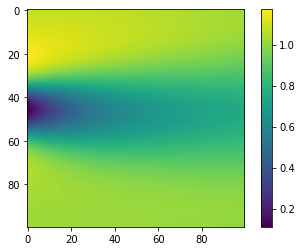

In [ ]:
uplot=np.reshape(u_pred,(100,100))
plt.imshow(uplot)
plt.colorbar()

# Plotting the actual velocity 

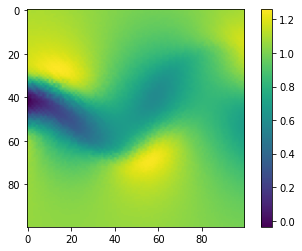

In [ ]:
upl=np.reshape(u_star,(100,100))
plt.imshow(upl)
plt.colorbar()